# Reduced FWI

This file is a demo of frequency domain FWI solved by the reduced problem.
The problem is:
$$\min_{M} J(m) = \frac{1}{2}\|P A(m)^{-1}q - d\|^2_2.$$

Here the PDE constraint is Helmholtz equation:
$$A(m) u = q.$$

To solve the problem we follow the routine of computing gradient by the adjoint method.
Blue dot is for source and orange dot is for receiver.

In minimization LBFGS-B were used.

In [2]:
include("program/model.jl");
include("program/make_diff_op.jl")
include("program/make_projection_op.jl")
include("program/make_source_vec.jl")
include("program/compute_gradient.jl")
include("program/lbfgsb_fwi.jl")
include("program/draw_figure.jl")

draw_wavefield (generic function with 1 method)

## Model 1

In [3]:
using ImageFiltering, JLD2

Nx = 51; Ny = 51;
dx = 20; dy = 20;
pml_len = 30;

# source and receiver
coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = 2;
    coor_source[i,2] = i;
end

coor_receiver = ones(Int,102, 2);
for i = 1:102
    coor_receiver[i,1] = 50;
    coor_receiver[i,2] = i;
end
for i = 52:102
    coor_receiver[i,1] = 2;
    coor_receiver[i,2] = i-51;
end

model = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

# Build the velocity model
pml_len = model.pml_len;
Nx_pml = model.Nx + 2*pml_len;
Ny_pml = model.Ny + 2*pml_len;

vel0 = 2000*ones(model.Nx, model.Ny);
vel = 2000*ones(model.Nx, model.Ny);
vel[21:36, :] .= 2100;
vel[37:51, :] .= 2200;
# vel[21:31, 21:31] .= 2100;
vel0_ex = extend_vel(vel0, model);
vel_ex = extend_vel(vel, model);
vel0_ex = imfilter(vel_ex, Kernel.gaussian(10));

vel_ex = reshape(vel_ex, Nx_pml*Ny_pml);
vel0_ex = reshape(vel0_ex, Nx_pml*Ny_pml);

# Solve the equation A(m)u = q
Pr = make_projection_op(model);
fre = 4;
A = make_diff_op(vel_ex, model, fre);
q = make_source_vec(model);
u = A \ q;|
d = Pr * u;

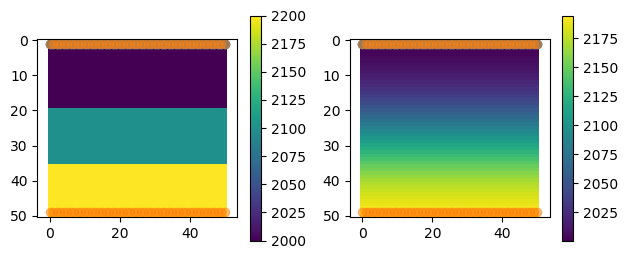

In [4]:
draw_model2(vel_ex, vel0_ex, model; vertial=false)

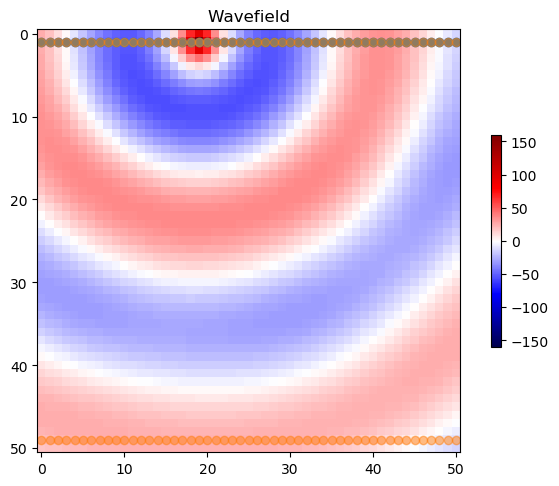

PyObject Text(0.5, 1.0, 'Wavefield')

In [5]:
draw_wavefield(u, model, index=20, ex_model=false); title("Wavefield")

In [6]:
# fre_vec = [5 10]
# lower = 2000
# upper = 2200
# result = lbfgsb_fwi(vel_ex, vel0_ex, model, fre_vec, lower, upper; iterTime=20);
@load "data/example1.jld2" result

1-element Array{Symbol,1}:
 :result

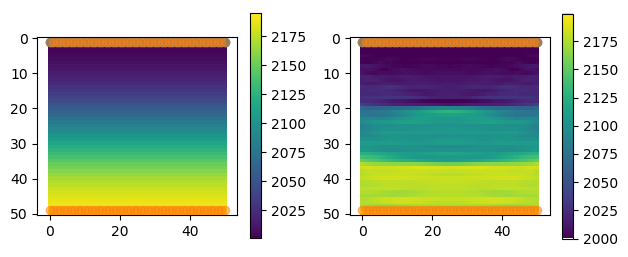

In [7]:
draw_model2(vel0_ex, result, model; vertial=false)

## Model 2

In [8]:
using JLD2
@load "data/overthrust_small.jld2" vel_true vel_init
vel_true = copy(vel_true');
vel_init = copy(vel_init');

Nx, Ny = size(vel_true)
dx = 25; dy = 25
pml_len = 30;

# source and receiver
coor_source = ones(Int, 101, 2);
source = -1 .* ones(101);

for i = 1:101
    coor_source[i,1] = 2;
    coor_source[i,2] = (i-1)*4+1;
end

coor_receiver = ones(Int,101, 2);
for i = 1:101
    coor_receiver[i,1] = 2;
    coor_receiver[i,2] = (i-1)*4+1;
end

model = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel_true = extend_vel(vel_true, model);
vel_init = extend_vel(vel_init, model);
Nx_pml = model.Nx + 2*pml_len;
Ny_pml = model.Ny + 2*pml_len;
vel_true = reshape(vel_true, Nx_pml*Ny_pml);
vel_init = reshape(vel_init, Nx_pml*Ny_pml);

# Solve the equation A(m)u = q
Pr = make_projection_op(model);
fre = 18;
A = make_diff_op(vel_true, model, fre);
q = make_source_vec(model);
@time u = A \ q;|
d = Pr * u;

 11.989385 seconds (608 allocations: 1.198 GiB, 6.64% gc time)


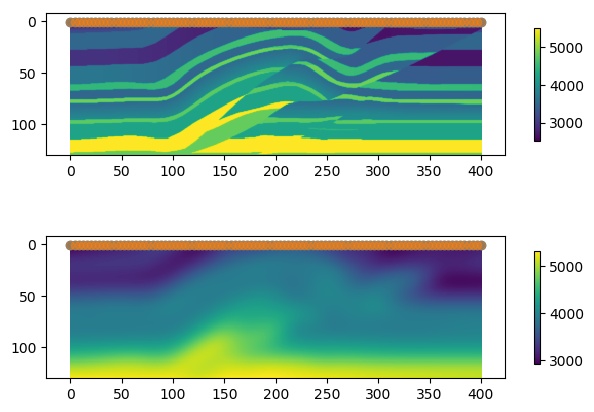

In [9]:
draw_model2(vel_true, vel_init, model; vertial=true)

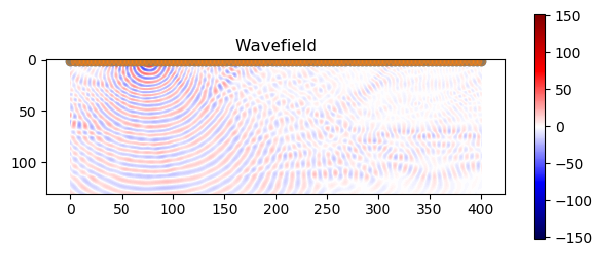

PyObject Text(0.5, 1.0, 'Wavefield')

In [10]:
draw_wavefield(u, model, index=20, ex_model=false); title("Wavefield")

In [11]:
# lower = minimum(vel_true)
# upper = maximum(vel_true)
# fre_vec = [4 8 10 14 18]
# result = lbfgsb_fwi(vel_true, vel_init, model, fre_vec, lower, upper; iterTime=10);
@load "data/example2.jld2" result

1-element Array{Symbol,1}:
 :result

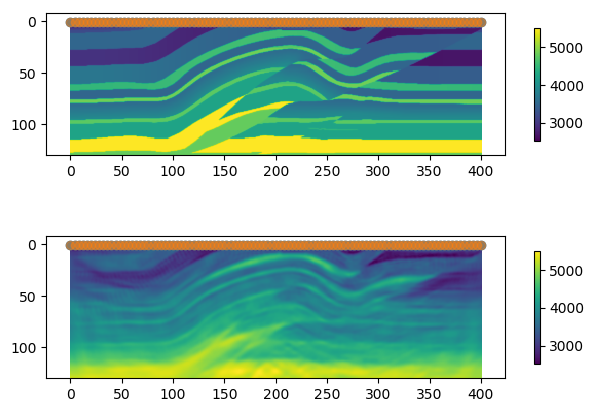

In [12]:
draw_model2(vel_true, result, model)